# 01_Data_Exploration.ipynb

**Project context**  
We want to know whether EchoNest’s *per-beat timbre vectors*  
(224 values per track) hide enough information to predict Russell’s four mood
quadrants (Happy · Tense · Sad · Relaxed).

This notebook **only describes and visualises** the data.  
Model building will happen in **02_RF_Mood_Prediction.ipynb**.


---

## Inputs produced by 00_Data_Cleaning.ipynb
| CSV                           | rows × cols | brief content                                       |
|-------------------------------|-------------|-----------------------------------------------------|
| `echonest_audio_features.csv` | 13 129 × 8  | global features (valence, energy, danceability …)   |
| `echonest_audio_temporal.csv` | 13 129 × 224| per-beat timbre PCA score (beat 0 – 223)            |


### Notebook roadmap
1. **Global valence + energy** → build quadrant labels, check class balance  
2. **Temporal vectors** → padding, spike + decay shape, data-wide stats  
3. **Take-aways** → why these findings justify a predictive model


In [30]:
# Imports & data paths ----------------------------------------------------
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 120 ; sns.set_style("whitegrid")

BASE = "/Users/angel/emotion_audio_gan/data/fma"
df_global   = pd.read_csv(f"{BASE}/echonest_audio_features.csv",  index_col="track_id")
df_temporal = pd.read_csv(f"{BASE}/echonest_audio_temporal.csv", index_col="track_id")  # 224 beat_* cols

# assure perfect row alignment
assert (df_global.index == df_temporal.index).all()

VAL, ENG = "valence", "energy"
print("global:", df_global.shape, "| temporal:", df_temporal.shape)
# Interpretation – 13 129 tracks, 8 globals, 224 beat columns


global: (13129, 8) | temporal: (13129, 224)


### About EchoNest features

* **Global table** – eight Spotify-style summary stats per track  
  | name | plain-English meaning |
  |------|----------------------|
  | valence | musical positivity |
  | energy  | perceptual intensity |
  | acousticness | “unplugged” quality |
  | danceability | how rhythmic & even |
  | instrumentalness | vocal vs instrumental |
  | liveness | crowd & room presence |
  | speechiness | spoken words ratio |
  | tempo | beats per minute |

* **Temporal table** – a single **timbre PCA score per beat**.  
  EchoNest originally extracts 12-D timbre vectors every beat;  
  the FMA authors kept only the **1st principal component** and fixed length to **224 beats** (≈ two 4-bar phrases × 16 repetitions).


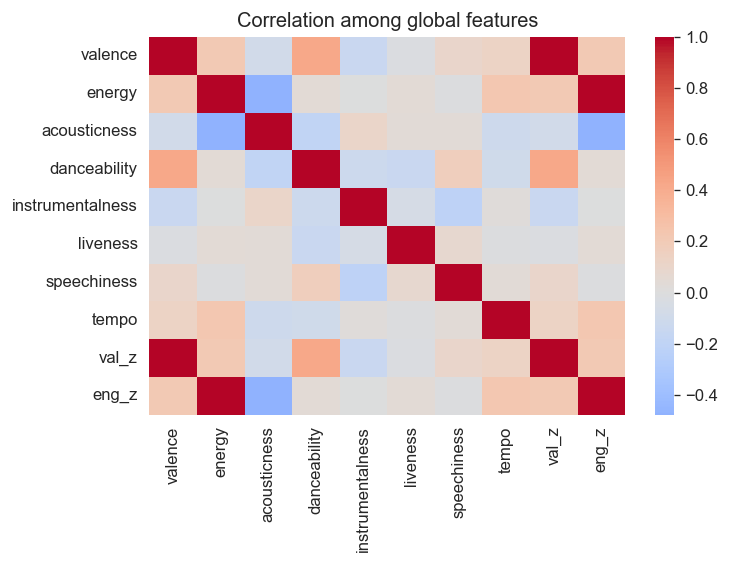

In [38]:
# Global-feature correlations  (numeric only) ----------------------------
num_cols = df_global.select_dtypes("number")     # drops 'quad'
corr_mtx = num_cols.corr()

sns.heatmap(corr_mtx, cmap="coolwarm", center=0, annot=False)
plt.title("Correlation among global features"); plt.tight_layout(); plt.show()
# Interpretation – valence weakly correlates with energy; others mostly independent


---

## 1 · Global valence + energy
Two scalar descriptors per track map directly onto the Russell plane.


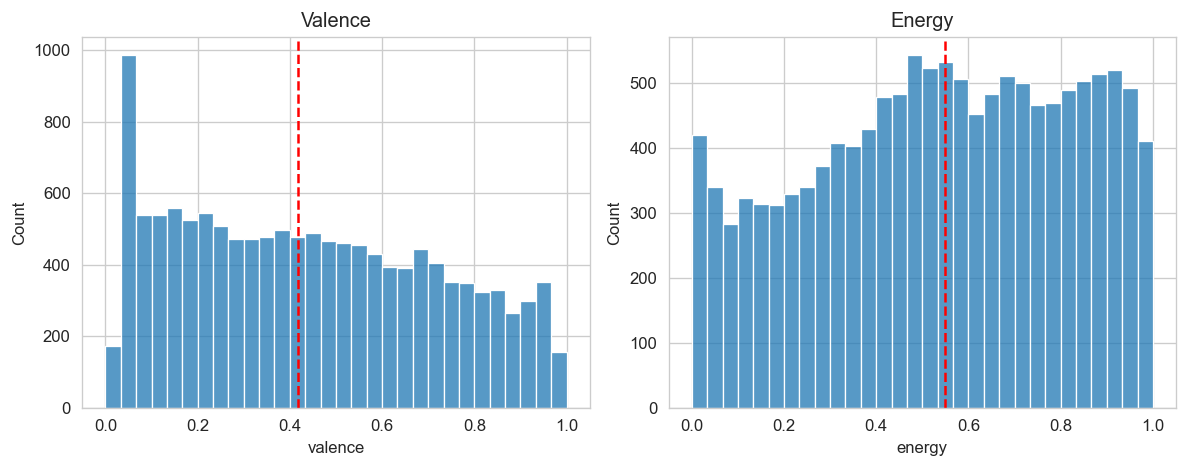

In [32]:
# 1A Histogram quick look -------------------------------------------------
fig, ax = plt.subplots(1,2,figsize=(10,4))
for feat,a in zip([VAL, ENG], ax):
    sns.histplot(df_global[feat], bins=30, ax=a)
    a.axvline(df_global[feat].median(), ls="--", c="red")
    a.set_title(feat.capitalize())
plt.tight_layout(); plt.show()
# Interpretation – valence skews low; energy roughly uniform


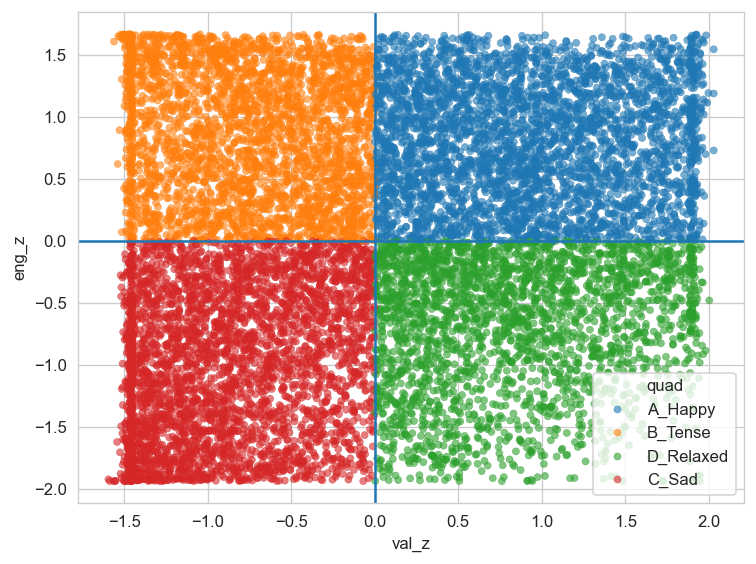

In [33]:
# 1B Quadrant labels & scatter -------------------------------------------
from sklearn.preprocessing import StandardScaler
df_global[["val_z","eng_z"]] = StandardScaler().fit_transform(df_global[[VAL, ENG]])

def quad(r):
    if   r.val_z>=0 and r.eng_z>=0: return "A_Happy"
    elif r.val_z<0 and r.eng_z>=0:  return "B_Tense"
    elif r.val_z<0 and r.eng_z<0:   return "C_Sad"
    else:                           return "D_Relaxed"
df_global["quad"] = df_global.apply(quad, axis=1)

sns.scatterplot(data=df_global, x="val_z", y="eng_z",
                hue="quad", s=18, alpha=.6, edgecolor=None)
plt.axhline(0); plt.axvline(0); plt.tight_layout(); plt.show()
# Interpretation – four clean blocks = mood labels


/var/folders/kw/zlk8mmp90m79ss21dh02ygrh0000gn/T/ipykernel_15997/1661245173.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="muted")


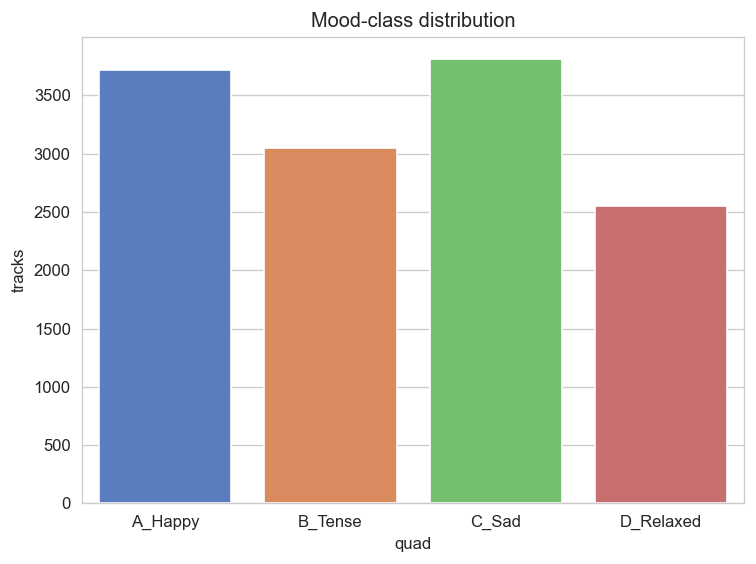

Proportions: {'A_Happy': 0.283, 'B_Tense': 0.232, 'C_Sad': 0.29, 'D_Relaxed': 0.194}


In [34]:
# 1C Class balance --------------------------------------------------------
counts = df_global["quad"].value_counts().sort_index()
sns.barplot(x=counts.index, y=counts.values, palette="muted")
plt.ylabel("tracks"); plt.title("Mood-class distribution"); plt.tight_layout(); plt.show()
print("Proportions:", (counts/counts.sum()).round(3).to_dict())
# Interpretation – slight imbalance; we will stratify splits & may use class-weights


---

## 2 · Temporal 224-beat vectors
Fixed length; zeros pad the right when songs are shorter than 224 beats.


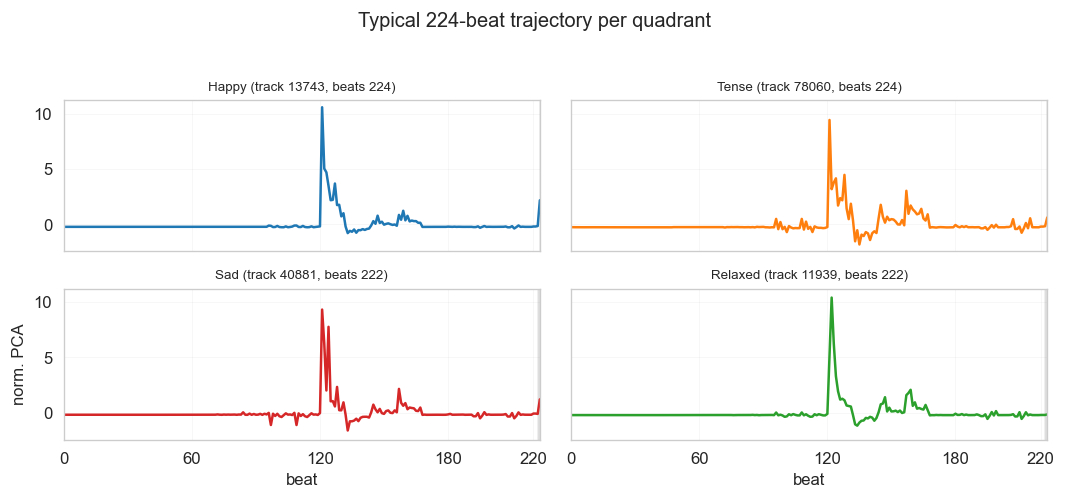

In [35]:
# 2A One random trajectory per quadrant ----------------------------------
import random
clr = dict(A_Happy="tab:blue", B_Tense="tab:orange",
           C_Sad="tab:red",  D_Relaxed="tab:green")

fig, axs = plt.subplots(2,2,figsize=(9,4), sharex=True, sharey=True)
for ax,q in zip(axs.ravel(), clr):
    tid = random.choice(df_global[df_global["quad"]==q].index)
    raw = df_temporal.loc[tid].values
    z   = (raw - raw.mean()) / (raw.std()+1e-9)
    nz  = (raw!=0).sum()
    ax.plot(z, color=clr[q]); ax.axvspan(nz,223,color='grey',alpha=.15)
    ax.set_title(f"{q.split('_')[1]} (track {tid}, beats {nz})", fontsize=8)
    ax.set_xlim(0,223); ax.set_xticks([0,60,120,180,220]); ax.grid(alpha=.3,lw=.3)
axs[1,0].set_ylabel("norm. PCA"); axs[1,0].set_xlabel("beat"); axs[1,1].set_xlabel("beat")
plt.suptitle("Typical 224-beat trajectory per quadrant", y=1.03)
plt.tight_layout(); plt.show()
# Interpretation – chorus spike ~120; decay shape differs by mood; grey = padding


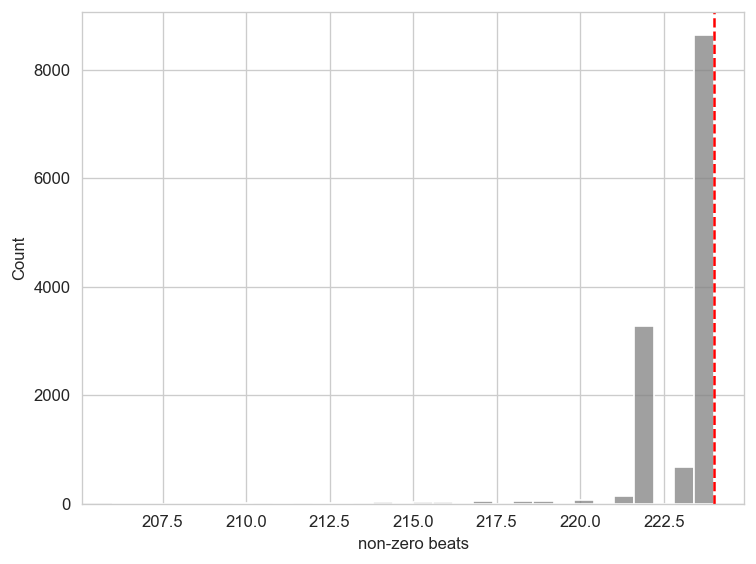

In [36]:
# 2B Real beat-length distribution ---------------------------------------
real_len = (df_temporal!=0).sum(axis=1)
sns.histplot(real_len, bins=30, color='gray')
plt.axvline(224, ls='--', c='red'); plt.xlabel("non-zero beats"); plt.tight_layout(); plt.show()
# Interpretation – most songs finish 210-224 beats; padding is short & consistent


---

## 3 · Take-aways
* Quadrants from valence + energy give clear labels; slight imbalance → stratify later.  
* Temporal vectors: spike & decay patterns vary by mood; padding is well understood.  
* These findings motivate training a Random-Forest in **02_RF_Mood_Prediction.ipynb**.



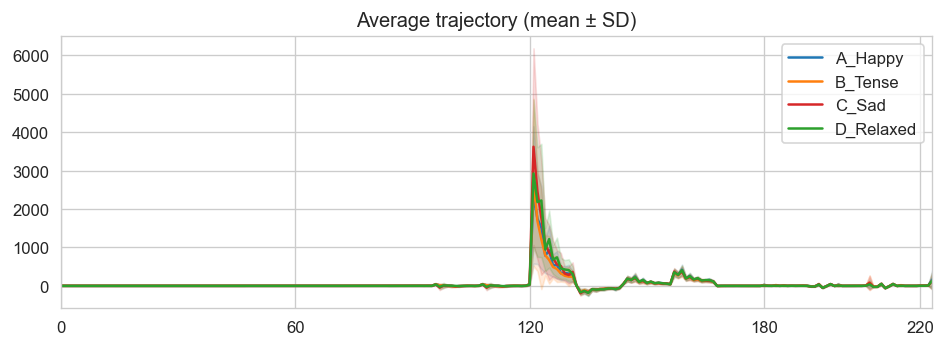

In [37]:
# 2C  Average trajectory ±1 SD per quadrant ------------------------------
clr = dict(A_Happy="tab:blue", B_Tense="tab:orange",
           C_Sad="tab:red",  D_Relaxed="tab:green")

fig, ax = plt.subplots(figsize=(8,3))
for q,c in clr.items():
    Z = df_temporal.loc[df_global["quad"] == q].to_numpy(dtype=float)     # (n,224)
    m = Z.mean(axis=0)                       # 224-long ndarray
    s = Z.std(axis=0)
    x = np.arange(224)
    ax.plot(x, m, color=c, label=q)
    ax.fill_between(x, m - s, m + s, color=c, alpha=.15)
ax.set_xlim(0,223); ax.set_xticks([0,60,120,180,220]); ax.legend()
plt.title("Average trajectory (mean ± SD)"); plt.tight_layout(); plt.show()
# Interpretation – systematic spike/decay differences suggest predictability

